In [1]:
import platform
print(platform.python_version())

3.5.2


In [2]:
import matplotlib as mpl
mpl.use('TkAgg')
%matplotlib inline
import numpy as np
import pandas as pd
import sklearn #note using 0.18
from sklearn.datasets import make_blobs
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures

In [3]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, colorConverter, LinearSegmentedColormap

In [4]:
from scipy import ndimage

In [5]:
mask = np.ones(27, dtype=np.bool) # 1 by len(X) array
mask
mask[np.array([0, 1, 5, 26])] = 0
mask

array([False, False,  True,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False], dtype=bool)

In [6]:
#make arbitrary two feature data set (for classfication)
def make_forge():
    #make_blobs gens X array of shape [n_samples, n_features] (the samples) and Y array of shape [n samples] (labels)
    X, y = make_blobs(centers=2, random_state=4, n_samples=30) 
    y[np.array([7, 27])] = 0
    mask = np.ones(len(X), dtype=np.bool) # 1 by len(X) array
    mask[np.array([0, 1, 5, 26])] = 0
    X, y = X[mask], y[mask]
    return X, y

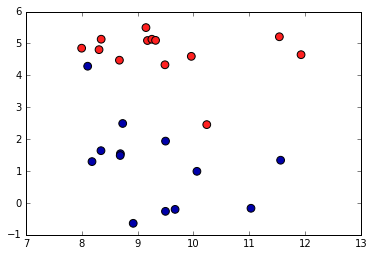

In [7]:
X, y = make_forge()
plt.scatter(X[:, 0], X[:, 1], c=y, s=60, cmap=ListedColormap(['#0000aa', '#ff2020']))

In [8]:
#make arbitrary wave data set (for regression)
def make_wave(n_samples=100):
    rnd = np.random.RandomState(42)
    x = rnd.uniform(-3, 3, size=n_samples)
    y_no_noise = (np.sin(4 * x) + x)
    y = (y_no_noise + rnd.normal(size=len(x))) / 2
    return x.reshape(-1, 1), y


(-3.1, 3.1)

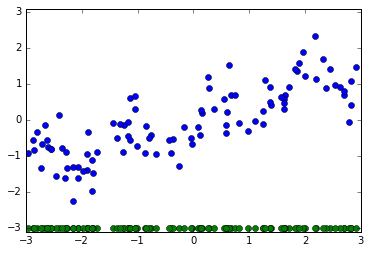

In [9]:
X, y = make_wave()
plt.plot(X, y, 'o')
plt.plot(X, -3*np.ones(len(X)), 'o')
plt.ylim(-3.1, 3.1)

In [10]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

In [11]:
cancer.keys()

dict_keys(['target_names', 'DESCR', 'feature_names', 'target', 'data'])

In [12]:
cancer.data.shape

(569, 30)

In [13]:
cancer.target_names

array(['malignant', 'benign'], 
      dtype='<U9')

In [14]:
from sklearn.datasets import load_boston
def load_extended_boston():
    boston = load_boston()
    X = boston.data
    X = MinMaxScaler().fit_transform(boston.data) #scales feature to a given range
    X = PolynomialFeatures(degree=2, include_bias=False).fit_transform(X) #generate new feature matrix 
    #generates derived features by generating products between features
    return X, boston.target #returns a modified version of the boston data. keeps the target array unchanged


In [15]:
"""KNeighbors Classification"""

'KNeighbors Classification'

In [16]:
from sklearn.model_selection import train_test_split
X, y = make_forge()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [17]:
range(1, 11)

range(1, 11)

In [18]:
from sklearn.neighbors import KNeighborsClassifier
clf = KNeighborsClassifier(n_neighbors=3)

In [19]:
clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform')

In [20]:
clf.predict(X_test)

array([1, 0, 1, 0, 1, 0, 0])

In [21]:
clf.score(X_test, y_test)

0.8571428571428571

In [22]:
def plot_2d_separator(classifier, X, fill=False, ax=None, eps=None, alpha=1,
                      cm=ListedColormap(['#0000aa', '#ff2020']), linewidth=None, threshold=None, linestyle="solid"):
    if eps is None:
        eps = X.std() / 2.

    if ax is None:
        ax = plt.gca()

    x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
    y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
    xx = np.linspace(x_min, x_max, 100)
    yy = np.linspace(y_min, y_max, 100)

    X1, X2 = np.meshgrid(xx, yy)
    X_grid = np.c_[X1.ravel(), X2.ravel()]
    try:
        decision_values = classifier.decision_function(X_grid)
        levels = [0] if threshold is None else [threshold]
        fill_levels = [decision_values.min()] + levels + [decision_values.max()]
    except AttributeError:
        # no decision_function
        decision_values = classifier.predict_proba(X_grid)[:, 1]
        levels = [.5] if threshold is None else [threshold]
        fill_levels = [0] + levels + [1]
    if fill:
        ax.contourf(X1, X2, decision_values.reshape(X1.shape),
                    levels=fill_levels, alpha=alpha, cmap=cm)
    else:
        ax.contour(X1, X2, decision_values.reshape(X1.shape), levels=levels,
                   colors="black", alpha=alpha, linewidths=linewidth,
                   linestyles=linestyle, zorder=5)

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())


In [23]:
def plot_tree_partition(X, y, tree, ax=None):
    if ax is None:
        ax = plt.gca()
    eps = X.std() / 2.

    x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
    y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
    xx = np.linspace(x_min, x_max, 1000)
    yy = np.linspace(y_min, y_max, 1000)

    X1, X2 = np.meshgrid(xx, yy)
    X_grid = np.c_[X1.ravel(), X2.ravel()]

    Z = tree.predict(X_grid)
    Z = Z.reshape(X1.shape)
    faces = tree.apply(X_grid)
    faces = faces.reshape(X1.shape)
    border = ndimage.laplace(faces) != 0
    ax.contourf(X1, X2, Z, alpha=.4, cmap=ListedColormap(['#0000aa', '#ff2020']), levels=[0, .5, 1])
    ax.scatter(X1[border], X2[border], marker='.', s=1)

    discrete_scatter(X[:, 0], X[:, 1], y, ax=ax)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    return ax


In [24]:
def discrete_scatter(x1, x2, y=None, markers=None, s=10, ax=None,
                     labels=None, padding=.2, alpha=1, c=None, markeredgewidth=None):
    """Adaption of matplotlib.pyplot.scatter to plot classes or clusters.
    Parameters
    ----------
    x1 : nd-array
        input data, first axis
    x2 : nd-array
        input data, second axis
    y : nd-array
        input data, discrete labels
    cmap : colormap
        Colormap to use.
    markers : list of string
        List of markers to use, or None (which defaults to 'o').
    s : int or float
        Size of the marker
    padding : float
        Fraction of the dataset range to use for padding the axes.
    alpha : float
        Alpha value for all points.
    """
    if ax is None:
        ax = plt.gca()

    if y is None:
        y = np.zeros(len(x1))

    unique_y = np.unique(y)

    if markers is None:
        markers = ['o', '^', 'v', 'D', 's', '*', 'p', 'h', 'H', '8', '<', '>'] * 10

    if len(markers) == 1:
        markers = markers * len(unique_y)

    if labels is None:
        labels = unique_y

    # lines in the matplotlib sense, not actual lines
    lines = []

    current_cycler = mpl.rcParams['axes.prop_cycle']

    for i, (yy, cycle) in enumerate(zip(unique_y, current_cycler())):
        mask = y == yy
        # if c is none, use color cycle
        if c is None:
            color = cycle['color']
        elif len(c) > 1:
            color = c[i]
        else:
            color = c
        # use light edge for dark markers
        if np.mean(colorConverter.to_rgb(color)) < .4:
            markeredgecolor = "grey"
        else:
            markeredgecolor = "black"

        lines.append(ax.plot(x1[mask], x2[mask], markers[i], markersize=s,
                             label=labels[i], alpha=alpha, c=color,
                             markeredgewidth=markeredgewidth,
                             markeredgecolor=markeredgecolor)[0])

    if padding != 0:
        pad1 = x1.std() * padding
        pad2 = x2.std() * padding
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        ax.set_xlim(min(x1.min() - pad1, xlim[0]), max(x1.max() + pad1, xlim[1]))
        ax.set_ylim(min(x2.min() - pad2, ylim[0]), max(x2.max() + pad2, ylim[1]))

    return lines


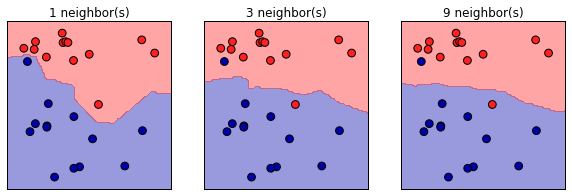

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
for n_neighbors, ax in zip([1, 3, 9], axes):
    clf = KNeighborsClassifier(n_neighbors = n_neighbors).fit(X, y) #for viz purposes didn't split the data set
    plot_2d_separator(clf, X, fill=True, eps=0.5, ax=ax, alpha=0.4)
    ax.scatter(X[:, 0], X[:, 1], c=y, s=60, cmap=ListedColormap(['#0000aa', '#ff2020']))
    ax.set_title("%d neighbor(s)" % n_neighbors)
    

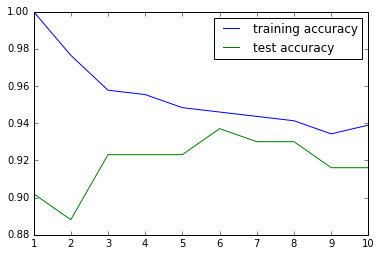

In [26]:
#so then the question is, how many neighbors to use?
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, 
                                                    stratify=cancer.target, random_state=66)
#stratify splitting using cancer.target as the labels array. divide members of the population into homogenous
#subgroups before sampling. necessary when subpops within an overall population vary

training_accuracy = []
test_accuracy = []

neighbors_settings = range(1, 11)

for n_neighbors in neighbors_settings:
    clf = KNeighborsClassifier(n_neighbors = n_neighbors)
    clf.fit(X_train, y_train) #train the classifier
    training_accuracy.append(clf.score(X_train, y_train))
    test_accuracy.append(clf.score(X_test, y_test))
    
plt.plot(neighbors_settings, training_accuracy, label = 'training accuracy')
plt.plot(neighbors_settings, test_accuracy, label = 'test accuracy')
plt.legend()
#more neighbors tends to decrease the accuracy of the training set, but increasing the neighbors up to a certain
#extent is good for the 

In [27]:
"K Neighbors Regression"

'K Neighbors Regression'

In [28]:
from sklearn.neighbors import KNeighborsRegressor
X, y = make_wave(n_samples = 40)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
reg = KNeighborsRegressor(n_neighbors = 3)
reg.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=3, p=2,
          weights='uniform')

In [29]:
reg.predict(X_test)

array([-0.05396539,  0.35686046,  1.13671923, -1.89415682, -1.13881398,
       -1.63113382,  0.35686046,  0.91241374, -0.44680446, -1.13881398])

In [30]:
reg.score(X_test, y_test)
#coeff of determination -> between 0 and 1. 0 corresponds to a model that always returns the mean of the training set
#1 is a perfect prediction

0.83441724462496036

In [31]:
"""K Neighbors is slow, can't handle too many features, not good when the data set has many features but
only a few are non-zero for any given data point"""

"K Neighbors is slow, can't handle too many features, not good when the data set has many features but\nonly a few are non-zero for any given data point"

In [32]:
"""LINEAR MODELS
For Regression"""

'LINEAR MODELS\nFor Regression'

In [33]:
"Linear Regression / ORDINARY LEAST SQUARES"

'Linear Regression / ORDINARY LEAST SQUARES'

In [34]:
#Extended Boston Data to test a multivariate Least Squares
from sklearn.linear_model import LinearRegression
X, y = load_extended_boston()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
lr = LinearRegression().fit(X_train, y_train)

/Users/vqc/anaconda/envs/py35/lib/python3.5/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


In [35]:
print ('training', lr.score(X_train, y_train))
print ('test', lr.score(X_test, y_test))

#training set has great score, but test set does not
#indicates overfitting on the model

training 0.952352643686
test 0.605775489294


In [36]:
"Ridge Regression"
#like OLS, but with the constraint that each feature is as close to 0 as possible, i.e. each feature
#has as little effect on the otucome as possible
from sklearn.linear_model import Ridge
ridge = Ridge().fit(X_train, y_train)
print ('training', ridge.score(X_train, y_train))
print ('test', ridge.score(X_test, y_test))

#can modify the "alpha", which is a number between 0 and 1 representing how much we want to restrict the 
#coefficients. a higher alpha means more restriction, a lower one less. an alpha results in a model that is
#very similar to the OLS (because an OLS doesn't restrict the coefficients at all)
#defaults alpha to 1

training 0.88605785604
test 0.752713960031


In [37]:
"Lasso Regression"
#like Ridge, but where it is possible for some coefficients to be exactly zero
from sklearn.linear_model import Lasso
lasso = Lasso().fit(X_train, y_train)
print ('training', lasso.score(X_train, y_train))
print ('test', lasso.score(X_test, y_test))
#underfits the data. can also use alpha to adjust. lower alpha means less constraint on the coeff which means
# a more complex model

training 0.293237689911
test 0.209375032553


In [38]:
"""LINEAR MODELS
FOR CLASSIFICATION

Several models
Differ in 1) the loss function (how it deals with combinations of coefficients and intercepts)
and 2) how it deals with regularization (prevent overfitting), by adding a term (the regularization term)
to the loss function

Two most common are Logistic Regression and Linear support vector machines (Linear SVMs)
For both of these the parameter that determines the strength of regularization is C. High values of C correspond to
less regularization. I.e. high C means the model will try to fit the training set as best as possible. Low C means
model puts more emphasis on finding a coefficient vector W that is close to zero.

High C means simple models

L1 versus L2 regularization. L1 means some feature have coeffs that go to 0. Useful if you assume that only 
some of your features are actually important. L2 minimizes but doesn't go to 0. L2 is a better default.

"""

"LINEAR MODELS\nFOR CLASSIFICATION\n\nSeveral models\nDiffer in 1) the loss function (how it deals with combinations of coefficients and intercepts)\nand 2) how it deals with regularization (prevent overfitting), by adding a term (the regularization term)\nto the loss function\n\nTwo most common are Logistic Regression and Linear support vector machines (Linear SVMs)\nFor both of these the parameter that determines the strength of regularization is C. High values of C correspond to\nless regularization. I.e. high C means the model will try to fit the training set as best as possible. Low C means\nmodel puts more emphasis on finding a coefficient vector W that is close to zero.\n\nHigh C means simple models\n\nL1 versus L2 regularization. L1 means some feature have coeffs that go to 0. Useful if you assume that only \nsome of your features are actually important. L2 minimizes but doesn't go to 0. L2 is a better default.\n\n"

c 0.001
training 0.922535211268
test 0.937062937063
c 1
training 0.955399061033
test 0.958041958042
c 100
training 0.974178403756
test 0.965034965035


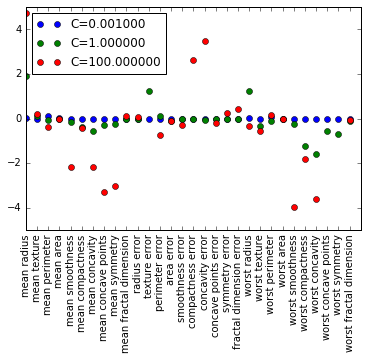

In [39]:
"""LinearLogistic (Logistic Regression)"""
from sklearn.linear_model import  LogisticRegression
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, 
                                                    stratify=cancer.target, random_state=42)

for c in [0.001, 1, 100]:
    logistic_regression = LogisticRegression(C=c).fit(X_train, y_train) #defaults to C=1 and a L2 regularization
    #l2 regularization pushes coefficients towards zero without becoming zero
    print ('c', c)
    print ('training', logistic_regression.score(X_train, y_train))
    print ('test', logistic_regression.score(X_test, y_test))
    plt.plot(logistic_regression.coef_.T, 'o', label="C=%f" % c)

plt.xticks(range(cancer.data.shape[1]), cancer.feature_names, rotation=90)
plt.ylim(-5, 5)
plt.legend(loc=2)


c 0.001
training 0.913145539906
test 0.923076923077
c 1
training 0.960093896714
test 0.958041958042
c 100
training 0.985915492958
test 0.979020979021


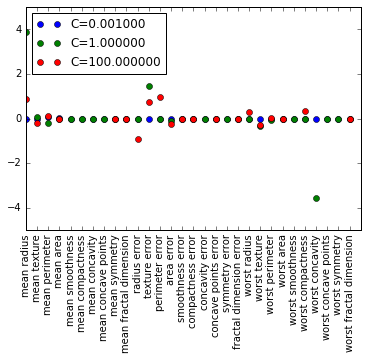

In [40]:
"""LinearLogistic (Logistic Regression)"""
from sklearn.linear_model import  LogisticRegression
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, 
                                                    stratify=cancer.target, random_state=42)
#try out L1 regularization ,i.e. pushes some coefficients to zero.
for c in [0.001, 1, 100]:
    logistic_regression = LogisticRegression(C=c, penalty='l1').fit(X_train, y_train) #defaults to C=1 and a L2 regularization
    #l2 regularization pushes coefficients towards zero without becoming zero
    print ('c', c)
    print ('training', logistic_regression.score(X_train, y_train))
    print ('test', logistic_regression.score(X_test, y_test))
    plt.plot(logistic_regression.coef_.T, 'o', label="C=%f" % c)

plt.xticks(range(cancer.data.shape[1]), cancer.feature_names, rotation=90)
plt.ylim(-5, 5)
plt.legend(loc=2)

In [41]:
"""Linear Models for multiclass classification
because most classification models are binary, common way to extend to multiclass is to treat it as a "one v rest"
problem. run as many classifiers as there are classes, and see which classifier gets the highest "one v rest" score.
the one with the highest score goes into that class.
"""

'Linear Models for multiclass classification\nbecause most classification models are binary, common way to extend to multiclass is to treat it as a "one v rest"\nproblem. run as many classifiers as there are classes, and see which classifier gets the highest "one v rest" score.\nthe one with the highest score goes into that class.\n'

(3, 2)
(3,)


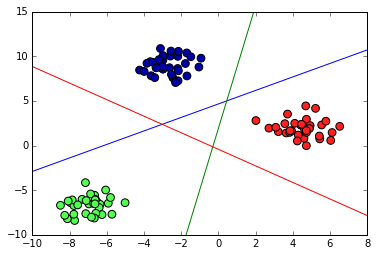

In [42]:
from sklearn.svm import  LinearSVC #sklearn implementation of LinearSVC supports multiclass
X, y = make_blobs(random_state=42) #default is 3 centers, 2 features, 100 samples


linear_svm = LinearSVC().fit(X, y)
line = np.linspace(-15, 15)
for coef, intercept in zip(linear_svm.coef_, linear_svm.intercept_):
    plt.plot(line, -(line *coef[0] + intercept)/coef[1])
plt.ylim(-10, 15)
plt.xlim(-10, 8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=60, cmap=ListedColormap(['#0000aa', '#ff2020', '#50ff50']))


print(linear_svm.coef_.shape) 
#3 rows 2 columns. each row represents each of the 3 possible classes, and contains one coefficient for 
#each of the features. the intercept has a shape of 3, 
print(linear_svm.intercept_.shape)

In [43]:
"""NAIVE BAYES
3 types of Bayes implemented in scikit learn
GaussianNB (continuous data): rarely used by practioners
BernoulliNB (binary data => 0 or 1)
MultinomialNB (count data => each feature represents an integer count of something)

Multi and Bern have a parameter alpha that is used to control model complexity. higher alpha smooths the model
resulting in a less complex model.

Very similar to linear models. faster to train. works well with high-dimensional sparse data. often used on large
datasets where training a linear model might take too long.
"""

'NAIVE BAYES\n3 types of Bayes implemented in scikit learn\nGaussianNB (continuous data): rarely used by practioners\nBernoulliNB (binary data => 0 or 1)\nMultinomialNB (count data => each feature represents an integer count of something)\n\nMulti and Bern have a parameter alpha that is used to control model complexity. higher alpha smooths the model\nresulting in a less complex model.\n\nVery similar to linear models. faster to train. works well with high-dimensional sparse data. often used on large\ndatasets where training a linear model might take too long.\n'

In [44]:
"""DECISION TREES
widely used for regression and classification
imagine a series of if-else questions

each node is either a question or a terminal node (aka a leaf) which contains the answer
each question is called a "test"

usually data does not come in binary yes/no features, but is rather represented as continuos features 

tree forming works by partioning data until each region in the partition only contains a single target value
(e.g. a single class or single regression value). a leaf containing only one target value is called "pure".

a prediction on a new data point is made by traversing the tree from root and going left or right depending on
whether the test is fulfilled.

Ending up witih pure leaves means that you have likely overfit the model. Two strategies to prevent overfitting:
1) pre-pruning, stopping the creation of the tree early; 2) building the tree but then removing nodes that contain
little information.

Strategie for prepruning include a) limiting max depth of the tree, b) limiting max number of leaves, or 
c) requiring a minimum number of points in a node to keep splitting it

scikit learn only implements pre-pruning

Params that control model complexity (prevent overfitting) are the pre-pruning (at least in scikit, 
it's only pre-pruning) params that stopt he building of the tree before it is fully developed. 
max_depth, max_leaf_nodes, min_samples_leaf.

Decision trees work well when you have features that are on completely different scales, or a mix of binary and
continuous features.

Downside is that decision trees tend to overfit, and provide poor generalization performance. As a result, 
ensemble methods are used in place of a single tree.

"""

'DECISION TREES\nwidely used for regression and classification\nimagine a series of if-else questions\n\neach node is either a question or a terminal node (aka a leaf) which contains the answer\neach question is called a "test"\n\nusually data does not come in binary yes/no features, but is rather represented as continuos features \n\ntree forming works by partioning data until each region in the partition only contains a single target value\n(e.g. a single class or single regression value). a leaf containing only one target value is called "pure".\n\na prediction on a new data point is made by traversing the tree from root and going left or right depending on\nwhether the test is fulfilled.\n\nEnding up witih pure leaves means that you have likely overfit the model. Two strategies to prevent overfitting:\n1) pre-pruning, stopping the creation of the tree early; 2) building the tree but then removing nodes that contain\nlittle information.\n\nStrategie for prepruning include a) limitin

max-depth 1
training 0.922535211268
test 0.923076923077
max-depth 2
training 0.957746478873
test 0.909090909091
max-depth 3
training 0.976525821596
test 0.944055944056
max-depth 4
training 0.988262910798
test 0.951048951049
max-depth 5
training 0.995305164319
test 0.951048951049
max-depth 6
training 0.99765258216
test 0.937062937063
max-depth 7
training 1.0
test 0.937062937063
max-depth 8
training 1.0
test 0.937062937063
max-depth 9
training 1.0
test 0.937062937063


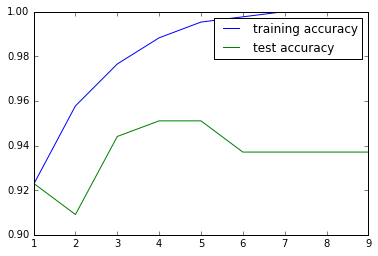

In [45]:
from sklearn.tree import DecisionTreeClassifier

cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, 
                                                    stratify=cancer.target, random_state=42)

training_accuracy = []
test_accuracy = []

for depth in range(1, 10):
    tree = DecisionTreeClassifier(max_depth = depth, random_state=0)
    tree.fit(X_train, y_train)
    print ('max-depth', depth)
    print ('training', tree.score(X_train, y_train))
    training_accuracy.append(tree.score(X_train, y_train))
    print ('test', tree.score(X_test, y_test))
    test_accuracy.append(tree.score(X_test, y_test))
    
plt.plot(range(1, 10), training_accuracy, label = 'training accuracy')
plt.plot(range(1, 10), test_accuracy, label = 'test accuracy')
plt.legend()

In [46]:
"""Visualizing """
from sklearn.tree import export_graphviz
tree = DecisionTreeClassifier(max_depth = 4, random_state=0)
tree.fit(X_train, y_train)
export_graphviz(tree, out_file="mytree.dot", class_names=['malignant', 'benign'],
               feature_names=cancer.feature_names, impurity=False, filled=True)

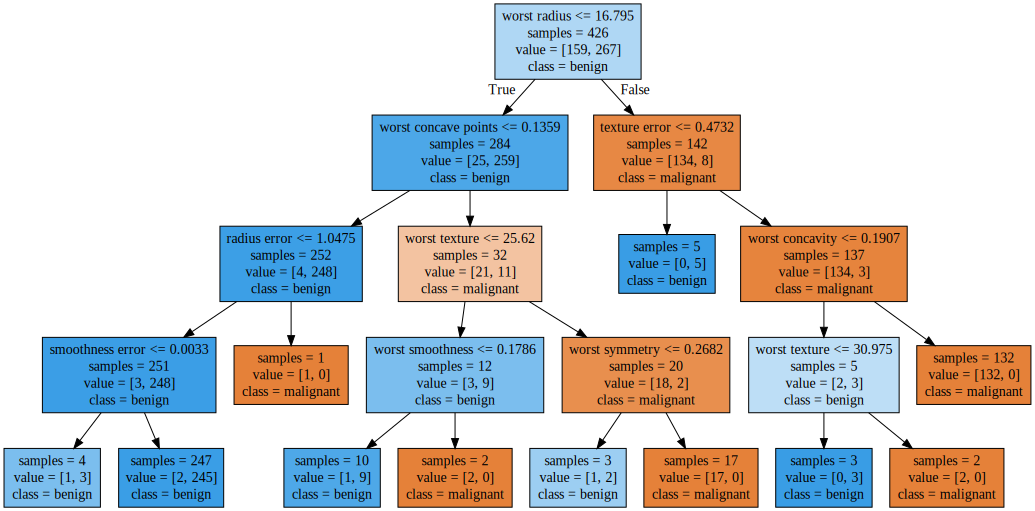

In [47]:
import graphviz #note install graphviz using pip not conda. the conda package isn't really a package
with open("mytree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

(0, 1)

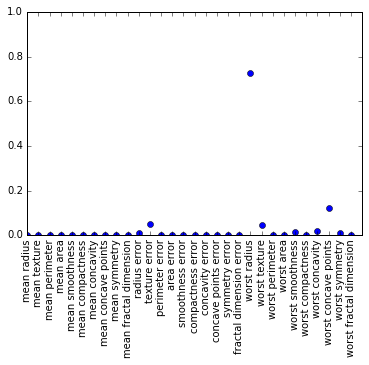

In [48]:
"""Tree Feature Importance
Rates how improtant each feature is for the decision made by the tree. It is number between 0 and 1, and 
the sum of all the features adds up to 1. 0 means not used at all. 1 means perfectly predicts the target."""
tree.feature_importances_
plt.plot(tree.feature_importances_, 'o')
plt.xticks(range(cancer.data.shape[1]), cancer.feature_names, rotation=90)
plt.ylim(0, 1)

In [49]:
"""ENSEMBLE OF DECISION TREES
Lots of variations, the two most common ones are Random Forests and Gradient Boosted Decision Trees
"""

'ENSEMBLE OF DECISION TREES\nLots of variations, the two most common ones are Random Forests and Gradient Boosted Decision Trees\n'

In [50]:
"""Random Forests
Essentially a collection of decision trees, where each tree is slightly different from the others.
Idea is to build many trees, each of which overfit in a different way, we can reduce the amount of overfitting
by averaging their results.
Two ways in which trees in a random forest are randomized: 1) by selecting the data points used to build a tree and 
2) by selecting the features in each split test

Building Random Forests
First decide the number of trees (n_estimator in RandomForestRegressor or RandomForestClassifer).

The sample for each tree is a bootstrapped sample of the original sample (i.e. same number of samples as original
but some samples are repeated and others are left out).

When building the tree, it is similar to building a single decision tree. But at each node, instead of looking for 
the best test for each node, in each node the algorithm randomly selects a subset of the features and looks
for the best test involving one of these features. The number of features selected for the pool depends on the 
parameter (max_features). If max_features is equal to the number of features in the set, than it will 
be the same as building a single tree.

Random forests are among the most widely used ML methods. Share benefits of decision trees while reducing
some deficiencies (i.e. overfitting). 

Tree building is parallelizable over cores. 

Random forests don't tend to perform very well on very high dimensional data, sparse data, such as text data. 
For this kind of data, linear models might be more appropriate.

Important parameters to adjust are n_estimators (number of trees to build), max_features (num features to 
consider when tree buildling, smaller max_features reduces overfitting) and pre-pruning options (i.e. (max_depth)). 
For n_estimators, larger is always better, but the tradeoff is memory and time.

Good default for max_features = sqrt(n_features) for classification and max_features = log2(n_features) for regression
"""

"Random Forests\nEssentially a collection of decision trees, where each tree is slightly different from the others.\nIdea is to build many trees, each of which overfit in a different way, we can reduce the amount of overfitting\nby averaging their results.\nTwo ways in which trees in a random forest are randomized: 1) by selecting the data points used to build a tree and \n2) by selecting the features in each split test\n\nBuilding Random Forests\nFirst decide the number of trees (n_estimator in RandomForestRegressor or RandomForestClassifer).\n\nThe sample for each tree is a bootstrapped sample of the original sample (i.e. same number of samples as original\nbut some samples are repeated and others are left out).\n\nWhen building the tree, it is similar to building a single decision tree. But at each node, instead of looking for \nthe best test for each node, in each node the algorithm randomly selects a subset of the features and looks\nfor the best test involving one of these featur

In [51]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, noise=0.25, random_state=3)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

forest = RandomForestClassifier(n_estimators = 5, random_state=2)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=5, n_jobs=1, oob_score=False, random_state=2,
            verbose=0, warm_start=False)

'The five different decision trees are quite different in what decision they made. Note that some of the\nmistakes made by the subtrees are not ponteially not actually mistakes, because the points might not have\nbeen included in their training set (because each tree gets a bootstrapped sample). '

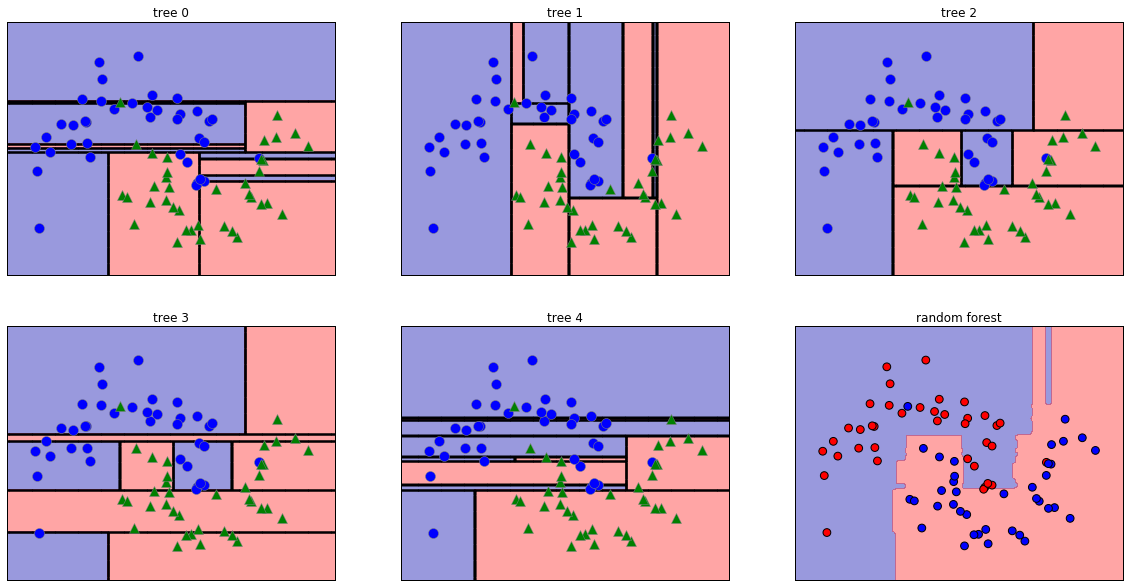

In [52]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
#forest.estimators_ contains the trees that are built as part of the random forest
for i, (ax, tree) in enumerate(zip(axes.ravel(), forest.estimators_)): #ravel returns a continuous flattened array
    ax.set_title("tree %d" % i)
    plot_tree_partition(X_train, y_train, tree, ax=ax)
plot_2d_separator(forest, X_train, fill=True, ax=axes[-1, -1], alpha=0.4)
axes[-1, -1].set_title("random forest")
plt.scatter(X_train[:, 0], X_train[:, 1], c=np.array(['r', 'b'])[y_train], s=60)

"""The five different decision trees are quite different in what decision they made. Note that some of the
mistakes made by the subtrees are not ponteially not actually mistakes, because the points might not have
been included in their training set (because each tree gets a bootstrapped sample). """

In [53]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

for estimators in [1, 10, 100, 1000]:
    forest = RandomForestClassifier(n_estimators=estimators, random_state=0)
    forest.fit(X_train, y_train)
    print ('estimators %d' % estimators)
    print ('training', forest.score(X_train, y_train))
    print ('test', forest.score(X_test, y_test))

"""
print ('predict test 1', 
       forest.predict(X_test[0].reshape(1, -1)), 
       forest.predict_proba(X_test[0].reshape(1, -1)),
      y_test[0])
print ('predict test 2', 
       forest.predict(X_test[10].reshape(1, -1)), 
       forest.predict_proba(X_test[10].reshape(1, -1)),
      y_test[10])

"""

#plt.plot(forest.feature_importances_, 'x')
#plt.xticks(range(cancer.data.shape[1]), cancer.feature_names, rotation=90)
"""When looking at feature importance, typically the feature importance provided by a random forest
are more reliable than the ones provided by a single tree. THe random forest gives non-zero importance to
many more features than the single tree. The fact that each tree considers a random subset of features 
means that each tree has to consider many different possible explanations for the data, which means
that the combined trees takes a much broader picture of the data."""

estimators 1
training 0.960093896714
test 0.881118881119
estimators 10
training 1.0
test 0.951048951049
estimators 100
training 1.0
test 0.972027972028
estimators 1000
training 1.0
test 0.972027972028


'When looking at feature importance, typically the feature importance provided by a random forest\nare more reliable than the ones provided by a single tree. THe random forest gives non-zero importance to\nmany more features than the single tree. The fact that each tree considers a random subset of features \nmeans that each tree has to consider many different possible explanations for the data, which means\nthat the combined trees takes a much broader picture of the data.'

learning rate 0.01, estimators 1
train 0.62676056338
test 0.629370629371
----------------
learning rate 0.01, estimators 10
train 0.62676056338
test 0.629370629371
----------------
learning rate 0.01, estimators 100
train 0.988262910798
test 0.965034965035
----------------
learning rate 0.01, estimators 1000
train 1.0
test 0.958041958042
----------------
learning rate 0.1, estimators 1
train 0.62676056338
test 0.629370629371
----------------
learning rate 0.1, estimators 10
train 0.985915492958
test 0.965034965035
----------------
learning rate 0.1, estimators 100
train 1.0
test 0.958041958042
----------------
learning rate 0.1, estimators 1000
train 1.0
test 0.965034965035
----------------
learning rate 1, estimators 1
train 0.976525821596
test 0.937062937063
----------------
learning rate 1, estimators 10
train 1.0
test 0.965034965035
----------------
learning rate 1, estimators 100
train 1.0
test 0.986013986014
----------------
learning rate 1, estimators 1000
train 1.0
test 0.98601

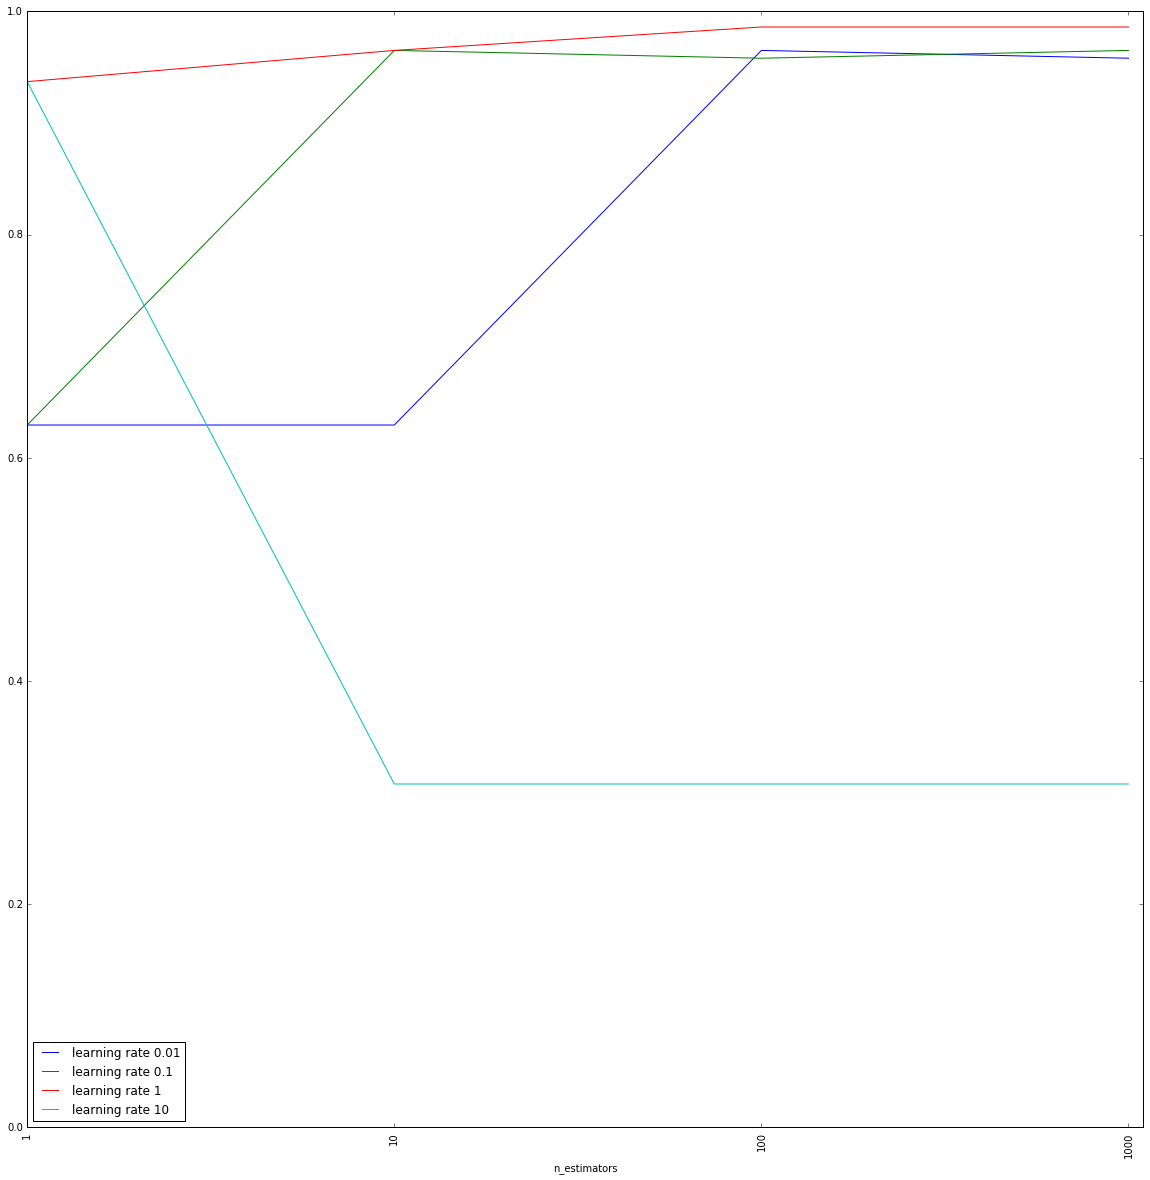

In [54]:
"""Gradient Boosted Regression Trees (Gradient Boosting Machines)
Also an Ensemble method that combines multiple trees
Although has Regression in the name, can be used for regression and classification

Unlike random forests, gradient boosting works by creating trees in a serial manner, where each successive tree
tries to correct the mistakes of the previous one. 

No randomization in GBR trees, strong pre-pruning used instead.
GB trees often use very shallow trees => depth of 1 to 5 as the pre-prune.

Each tree provides good prediction on only part of the data.

Other important parameters
learning_rate => how strongly each tree attempts to correct the mistakes of the previous tree. Higher learning rate
means stronger corrections which means more complex model. default is 0.1 in sklearn
n_estimators => number of trees default is 100 in sklearn

GB and random forest perform well on similar kinds of data. Usually try random forests first. If prediction time
is important or it is important to squeeze out additional accuracy, move to GB.

If large scale problem, look into xgboost. see below for some tuning
https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/

GB is powerful and widely used.
Main drawback is that careful tuning of params is required and make take a long time to train.
As with other tree-based models, often does not work well on high-dimensional sparse data.

Main params of gradient boosted trees are the number of trees (n_estimators) and the learning rate, which controls
how much each tree is allowed to correct the mistakes of previous trees.

Unlike random trees, in which higher n_estimators is always better, increasing n_estimators in gradient boosting
may lead to overfitting.

Common to fit n_estimators depending on time and memory limitations, and then search over diff learning_rates.

max_depth is also important. usually very low for gradient boosted. often not deeper than 5 splits.
"""
import math
from sklearn.ensemble import GradientBoostingClassifier
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111)



X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)
for learning_rate in [0.01, 0.1, 1, 10]:
    lr = []
    ne = []
    test_score = []
    for n_estimators in [1, 10, 100, 1000]:
        gbc = GradientBoostingClassifier(random_state = 0, 
                                        learning_rate = learning_rate,
                                       n_estimators = n_estimators)
        gbc.fit(X_train, y_train)
        lr.append(learning_rate)
        ne.append(n_estimators)
        test_score.append(gbc.score(X_test, y_test))
        print('learning rate {}, estimators {}'.format(learning_rate, n_estimators))
        print('train', gbc.score(X_train, y_train))
        print('test', gbc.score(X_test, y_test))
        print('----------------')
    plt.plot([math.log(i) for i in ne], test_score, label = 'learning rate {}'.format(learning_rate))

plt.xticks([math.log(i) for i in ne], ne, rotation=90)


plt.ylim(0, 1)
plt.legend(loc='best')
ax.set_xlabel('n_estimators')
#plt.yticks(ys, rotation=90)



([<matplotlib.axis.XTick at 0x1106719e8>,
 <a list of 30 Text xticklabel objects>)

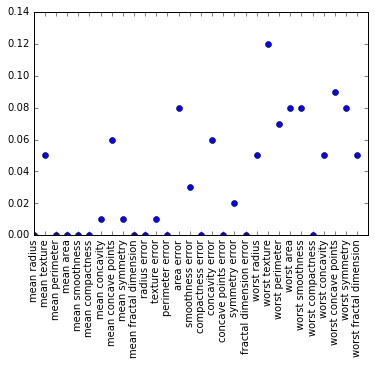

In [55]:
"""Visualize the feature importance in the gbc."""
gbc_1 = GradientBoostingClassifier(random_state = 0, max_depth=1)
gbc_1.fit(X_train, y_train)

plt.plot(gbc_1.feature_importances_, 'o')
plt.xticks(range(cancer.data.shape[1]), cancer.feature_names, rotation=90)

In [56]:
"""Kernalized Support Vector Machines (SVM)
Kernelized SVM are an extension of linear support vector machines that allows for more complex
models which are not defined simply by hyperplanes in the input space.

Add non-linear features to the representation of the data so that it is possible to use a linear model 
to separate the data. There is way to learn a classifier in a higher dimensional space without computing
the new higher dimensional space. AKA the kernel trick.

Kernel trick works by computing the scalar product of the data points for the expanded feature representation
without actually calculating out the expansion.

Two common kernels. The polynomial kernel (e.g. feature1 ** 2 * feature2 ** 5), and the radial basis function kernel
(aka the Gaussian kernel)

EXPLAINING SVMs
In training, SVM learns how improtant each of the training data points is to represent the decision boundary
between the two classes. Typically only a subset of the training points matter for defining the decision boundary, i.e.
the points that lie on the border between the classes. These are called support vectors.

To make a prediction for a new point, the distance to the support vector is measured. A classificaiton is made based
on the distance to the support vectors, and the importance of the support vectors that was learned during the training.

SVM has two improtant tunable parameters C, and gamma
C is a regularization param similar to linear models. It limits the importance of each point. A small C means a
restricted model, where each data point can only have very limited influence.

Gamma controls the width of the Gaussian kernel. it determines the scale of what it means for points to be
close together. A small gamme means a large radius for the Gaussian Kernel, which means many points are considered
close by. Which means a very smooth deicsion boundary. As gamma goes higher, fewer points are considered nearby, 
and the decision boundar becomes less smooth.

SVS are very sensitive to the tuning of the parameters (e.g. gamma, and C). 

Also to the scaling of the data => in
particular, they require all the features to vary on a similar scale. If the features are of completely different
orders of magnitude, that is really bad for SVM (less bad for linear models)

SVMs allow for complex decision boundaries, even if the data only has a few features.
Work well on low-dimensional and high-dimensional data.
Doesn't scale well with large samples (100k or more can be a problem)
Requires careful preprocessing of data.

"""

"Kernalized Support Vector Machines (SVM)\nKernelized SVM are an extension of linear support vector machines that allows for more complex\nmodels which are not defined simply by hyperplanes in the input space.\n\nAdd non-linear features to the representation of the data so that it is possible to use a linear model \nto separate the data. There is way to learn a classifier in a higher dimensional space without computing\nthe new higher dimensional space. AKA the kernel trick.\n\nKernel trick works by computing the scalar product of the data points for the expanded feature representation\nwithout actually calculating out the expansion.\n\nTwo common kernels. The polynomial kernel (e.g. feature1 ** 2 * feature2 ** 5), and the radial basis function kernel\n(aka the Gaussian kernel)\n\nEXPLAINING SVMs\nIn training, SVM learns how improtant each of the training data points is to represent the decision boundary\nbetween the two classes. Typically only a subset of the training points matter fo

In [57]:
def make_handcrafted_dataset():
    X, y = make_blobs(centers=2, random_state=4, n_samples=30)
    y[np.array([7, 27])] = 0
    mask = np.ones(len(X), dtype=np.bool)
    mask[np.array([0, 1, 5, 26])] = 0
    X, y = X[mask], y[mask]
    return X, y

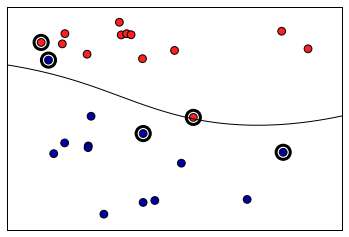

In [58]:
"""Example SVM"""
from sklearn.svm import SVC

X, y = make_handcrafted_dataset()
svm = SVC(kernel='rbf', C=10, gamma=0.1)
svm.fit(X, y)
plot_2d_separator(svm, X, eps=0.5)
#plot data
plt.scatter(X[:, 0], X[:, 1], s=60, c=y, cmap=ListedColormap(['#0000aa', '#ff2020']))
#plot support vectors
sv = svm.support_vectors_
plt.scatter(sv[:, 0], sv[:, 1], s=200, facecolors='none', zorder=10, linewidth=3)

In [59]:
def plot_svm(log_C, log_gamma, ax=None):
    X, y = make_handcrafted_dataset()
    C = 10. ** log_C
    gamma = 10. ** log_gamma
    svm = SVC(kernel='rbf', C=C, gamma=gamma).fit(X, y)
    if ax is None:
        ax = plt.gca()
    plot_2d_separator(svm, X, ax=ax, eps=.5)
    # plot data
    discrete_scatter(X[:, 0], X[:, 1], y, ax=ax)
    # plot support vectors
    sv = svm.support_vectors_
    # class labels of support vectors are given by the sign of the dual coefficients
    sv_labels = svm.dual_coef_.ravel() > 0
    discrete_scatter(sv[:, 0], sv[:, 1], sv_labels, s=15, markeredgewidth=3, ax=ax)
    ax.set_title("C = %.4f gamma = %.4f" % (C, gamma))


"\nFrom left to right, Gamma increases ,which means that many points are 'close by'. Thus from left to right, the\nleft is smooth, and the right focuses more on individual points.\nFrom top to bottom C increases. A small C means each point has little influence, and a bigger C means\neach point has a larger influence."

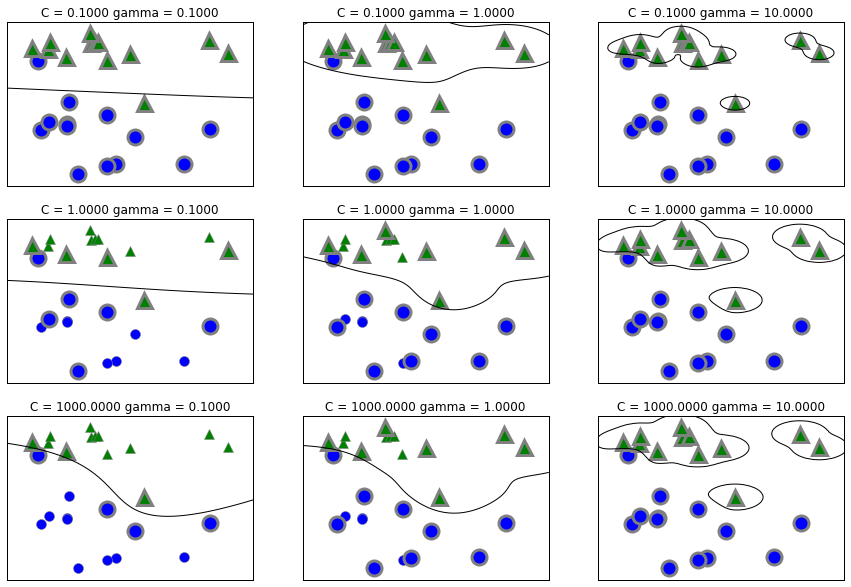

In [60]:
"""Visualizing tuning the C and gamma for an SVM

SVM has two improtant tunable parameters C, and gamma
C is a regularization param similar to linear models. It limits the importance of each point. A small C means a
restricted model, where each data point can only have very limited influence.

Gamma controls the width of the Gaussian kernel. it determines the scale of what it means for points to be
close together. A small gamme means a large radius for the Gaussian Kernel, which means many points are considered
close by. Which means a very smooth deicsion boundary. As gamma goes higher, fewer points are considered nearby, 
and the decision boundar becomes less smooth."""

fix, axes = plt.subplots(3, 3, figsize=(15, 10))
for ax, C in zip(axes, [-1, 0, 3]):
    for a, gamma in zip(ax, range(-1, 2)):
        plot_svm(log_C = C, log_gamma = gamma, ax=a)
    
"""
From left to right, Gamma increases ,which means that many points are 'close by'. Thus from left to right, the
left is smooth, and the right focuses more on individual points.
From top to bottom C increases. A small C means each point has little influence, and a bigger C means
each point has a larger influence."""

In [61]:
#testing the SVM on the breast cancer data set
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

svc = SVC()
svc.fit(X_train, y_train)
print ("training score is {}".format(svc.score(X_train, y_train)))
print ("test score is {}".format(svc.score(X_test, y_test)))

"""the scores indicate that the model is substantially overfit. 100% on training and 63% on testing."""

training score is 1.0
test score is 0.6293706293706294


'the scores indicate that the model is substantially overfit. 100% on training and 63% on testing.'

In [62]:
"""Preprocessing Data for SVMs
Because SVMs are so sensitive to differently scaled data, preprocessing is valuable.

One option to resove the magnitutde issue is to rescale each feature so that they are on the same scale, e.g.
all between 0 and 1.

One option is to use MinMaxScaler , but below is how to do it by hand.


"""

#compute the min value per feature in training set
min_training = X_train.min(axis=0)
range_training = (X_train - min_training).max(axis=0)
X_train_scaled = (X_train - min_training) / range_training
print("Min for each feature \n{}".format(X_train_scaled.min(axis=0)))
print("Max for each feature \n{}".format(X_train_scaled.max(axis=0)))

X_test_scaled = (X_test - min_training) / range_training
svc = SVC()
svc.fit(X_train_scaled, y_train)
        
print ("training score is {}".format(svc.score(X_train_scaled, y_train)))
print ("test score is {}".format(svc.score(X_test_scaled, y_test)))
#considering the underfit outcome in which trainign and test are quite similar, try changing the 
#C or gamma to fit a more complex model
print("increase C to 1000")
svc = SVC(C=1000)
svc.fit(X_train_scaled, y_train)
        
print ("training score is {}".format(svc.score(X_train_scaled, y_train)))
print ("test score is {}".format(svc.score(X_test_scaled, y_test)))


Min for each feature 
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Max for each feature 
[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]
training score is 0.9483568075117371
test score is 0.951048951048951
increase C to 1000
training score is 0.9882629107981221
test score is 0.972027972027972


In [73]:
"""Straight Forward Neural Networks
Multilayer perceptrons (MLPs) aka vanilla feed-forward neural networks, aka neural networks

First key part that separates a neural network from a linear model is the application of a non-linear
function to the output of a node. 
Common funcitons are rectifying nonlinearity aka rectified linear unit aka relu or the tangens hyperbolicus aka tanh
relu cuts off values below 0
tanh saturates to -1 for low input values and +1 for high input values.
Either non-linear funciton allows the neural network to learn much more complicated function than a linear model could.

Neural networks expect input features to value in a similar way, ideally with a mean of 0 and a variance of 1.

Take a long time to train.
Require careful pre processing of data.
Work best with homogenous data where all features have similar meanings. For data that has very different kinds
of features, tree based models might work better.

The most important params are a) the number of layers and b) the number of hidden units per layers. Generally
start with 1 or 2 hidden layers and possibly expand from there.
The number of nodes (units) per layer is often aroudn the number of input features, but rarely higher than in the
low ot mid thousands.

A common way to adjust params is to create a network that is large enough to overfit. Then once you know the 
training data can be learned, either shrink the size of the network or increase alpha to add regularization
which will improve generalization performance.

The algorithm also matters. Default in SKLearn is 'adam' which works well generally but is sensitive to scaling
of data. Another is 'l-bfgs' which is robust but might take a long time on larger models or larger data sets. Another
is 'sgd' which is what many deep learning researchers use, but it is more complicated with more params to be tuned.
"""

"Straight Forward Neural Networks\nMultilayer perceptrons (MLPs) aka vanilla feed-forward neural networks, aka neural networks\n\nFirst key part that separates a neural network from a linear model is the application of a non-linear\nfunction to the output of a node. \nCommon funcitons are rectifying nonlinearity aka rectified linear unit aka relu or the tangens hyperbolicus aka tanh\nrelu cuts off values below 0\ntanh saturates to -1 for low input values and +1 for high input values.\nEither non-linear funciton allows the neural network to learn much more complicated function than a linear model could.\n\nNeural networks expect input features to value in a similar way, ideally with a mean of 0 and a variance of 1.\n\nTake a long time to train.\nRequire careful pre processing of data.\nWork best with homogenous data where all features have similar meanings. For data that has very different kinds\nof features, tree based models might work better.\n\nThe most important params are a) the n

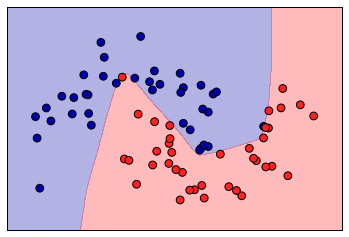

In [64]:
"""Tuning an MLP"""
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_moons
X, y = make_moons(n_samples = 100, noise = 0.25, random_state=3)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state = 42) 

mlp = MLPClassifier(algorithm='l-bfgs', random_state=0).fit(X_train, y_train)
#by default the mlp uses hidden_layer_sizes = 100. You can change this to something smaller and get a 
#more ragged, but still usable decision boundary (at least for this size data set)
#or increase to multiple hidden layers
plot_2d_separator(mlp, X_train, fill=True, alpha=0.3)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=60, cmap=ListedColormap(['#0000aa', '#ff2020']))



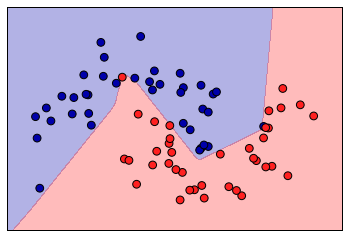

In [65]:
#two hidden layers
mlp = MLPClassifier(algorithm='l-bfgs', random_state=0, hidden_layer_sizes=[10, 10]).fit(X_train, y_train)
plot_2d_separator(mlp, X_train, fill=True, alpha=0.3)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=60, cmap=ListedColormap(['#0000aa', '#ff2020']))

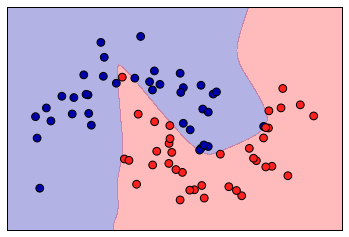

In [66]:
#change to tanh nonlinearity function
mlp = MLPClassifier(algorithm='l-bfgs', random_state=0, 
                    hidden_layer_sizes=[10, 10], activation='tanh').fit(X_train, y_train)
plot_2d_separator(mlp, X_train, fill=True, alpha=0.3)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=60, cmap=ListedColormap(['#0000aa', '#ff2020']))

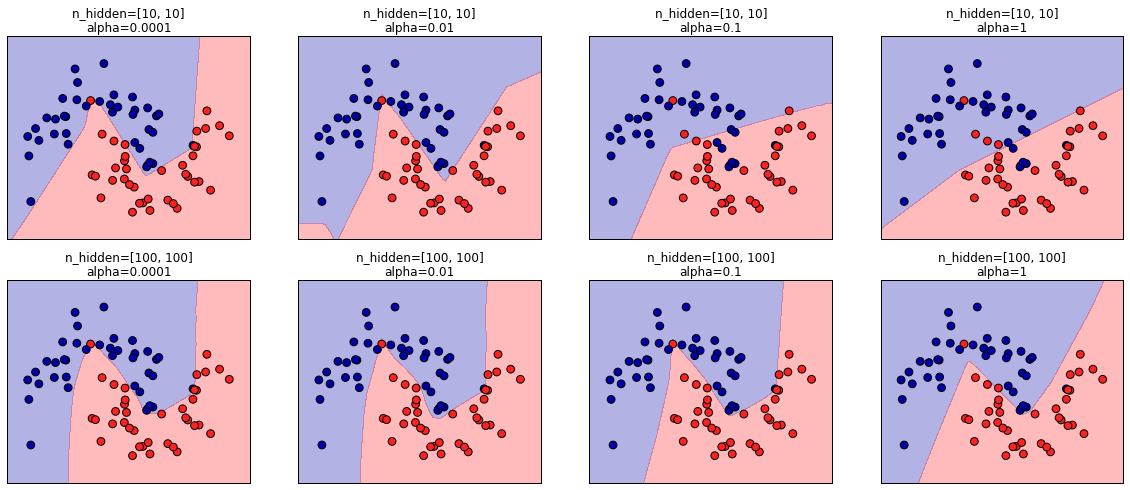

In [67]:
#can also change the alpha (the regularization of the features), i.e. l2 or l1 to shrink the weights of each feature
#just like in the linear models

fig, axes = plt.subplots(2, 4, figsize=(20, 8))
for ax, n_hidden_nodes in zip(axes, [10, 100]):
    for axx, alpha in zip(ax, [0.0001, 0.01, 0.1, 1]):
        mlp = MLPClassifier(algorithm='l-bfgs', random_state=0,
                           hidden_layer_sizes = [n_hidden_nodes, n_hidden_nodes], alpha = alpha)
        mlp.fit(X_train, y_train)
        plot_2d_separator(mlp, X_train, fill=True, alpha = .3, ax=axx)
        axx.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=60, cmap =ListedColormap(['#0000aa', '#ff2020']))
        axx.set_title("n_hidden=[{}, {}]\nalpha={}".format(n_hidden_nodes, n_hidden_nodes, alpha))

In [72]:
"""Apply MLPClassifier to the Breast Cancer Dataset"""
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, 
                                                    random_state = 0, stratify=cancer.target)
mlp = MLPClassifier()
mlp.fit(X_train, y_train)
print ("training score is {}".format(mlp.score(X_train, y_train)))
print ("test score is {}".format(mlp.score(X_test, y_test)))

#recale data to improve accuracy
mean_train = X_train.mean(axis=0)
std_train = X_train.std(axis=0)
#subtract the mean and scale by inverse standard deviation
X_train_scaled = (X_train - mean_train)/std_train
X_test_scaled = (X_test - mean_train)/std_train
mlp = MLPClassifier(random_state = 0, max_iter = 1000, alpha = 1)
mlp.fit(X_train_scaled, y_train)
print ("training score is {}".format(mlp.score(X_train_scaled, y_train)))
print ("test score is {}".format(mlp.score(X_test_scaled, y_test)))


training score is 0.931924882629108
test score is 0.8951048951048951
training score is 0.9906103286384976
test score is 0.965034965034965


In [74]:
"""UNCERTAINTY ESTIMATES FROM CLASSIFIERS
Goal is to determine how certain the model is that the prediction is correct.
Two functions in sklearn that can be used to obtain uncertainy estimates from classifiers: a) decision_function
and b) predict_proba. Most (not all) classifiers have one, and many have both.
"""

'UNCERTAINTY ESTIMATES FROM CLASSIFIERS\nGoal is to determine how certain the model is that the prediction is correct.\nTwo functions in sklearn that can be used to obtain uncertainy estimates from classifiers: a) decision_function\nand b) predict_proba. Most (not all) classifiers have one, and many have both.\n'

In [75]:
"""Uncertainty estimates in a gradient boosted tree"""
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import make_blobs, make_circles
X, y = make_circles(noise = 0.25, factor = 0.5, random_state=1)
y_named = np.array(['blue', 'red'])[y]

X_train, X_test, y_train_named, y_test_named, y_train, y_test = train_test_split(X, y_named, y, random_state=0)

gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train, y_train_named)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=0,
              subsample=1.0, verbose=0, warm_start=False)

In [81]:
print(X_test.shape) #row for each test item, and 2 features for each item
print(gbrt.decision_function(X_test).shape) #
print(gbrt.decision_function(X_test))
# the gbrt decision function encodes how strongly the model believes a data point belongs to a class.
#for binary classification, the "negative" class is always the first entry of the classes_ attribute.
print(gbrt.predict(X_test))
print(gbrt.classes_)
# the arbitrary scaling of the decision_function output makes it hard to interpret.

(25, 2)
(25,)
[ 4.13592629 -1.7016989  -3.95106099 -3.62599351  4.28986668  3.66166106
 -7.69097177  4.11001634  1.10753883  3.40782247 -6.46262729  4.28986668
  3.90156371 -1.20031192  3.66166106 -4.17231209 -1.23010022 -3.91576275
  4.03602808  4.11001634  4.11001634  0.65708962  2.69826291 -2.65673325
 -1.86776597]
['red' 'blue' 'blue' 'blue' 'red' 'red' 'blue' 'red' 'red' 'red' 'blue'
 'red' 'red' 'blue' 'red' 'blue' 'blue' 'blue' 'red' 'red' 'red' 'red'
 'red' 'blue' 'blue']
['blue' 'red']


In [83]:
print("predict_proba")
np.set_printoptions(suppress=True, precision=3)
print(gbrt.predict_proba(X_test).shape)
print(gbrt.predict_proba(X_test))
#probabilites sum to 1
#a model that is more overfit tends to make more certain predictions, even if they might be wrong.
# a model with less complexity usually has more uncertainty in predictions
#A model is "calibrated" if the reported uncertainty matches how correctly it is, e.g., if the prediction is
#70% certain, then it would be correct 70% of the time.

predict_proba
(25, 2)
[[ 0.016  0.984]
 [ 0.846  0.154]
 [ 0.981  0.019]
 [ 0.974  0.026]
 [ 0.014  0.986]
 [ 0.025  0.975]
 [ 1.     0.   ]
 [ 0.016  0.984]
 [ 0.248  0.752]
 [ 0.032  0.968]
 [ 0.998  0.002]
 [ 0.014  0.986]
 [ 0.02   0.98 ]
 [ 0.769  0.231]
 [ 0.025  0.975]
 [ 0.985  0.015]
 [ 0.774  0.226]
 [ 0.98   0.02 ]
 [ 0.017  0.983]
 [ 0.016  0.984]
 [ 0.016  0.984]
 [ 0.341  0.659]
 [ 0.063  0.937]
 [ 0.934  0.066]
 [ 0.866  0.134]]


In [84]:
"""Uncertainty in multi-class classification"""
from sklearn.datasets import load_iris

iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, random_state=42)
gbrt = GradientBoostingClassifier()
gbrt.fit(X_train, y_train)
print(gbrt.predict_proba(X_test).shape)
print(gbrt.predict_proba(X_test))

(38, 3)
[[ 0.     1.     0.   ]
 [ 1.     0.     0.   ]
 [ 0.     0.     1.   ]
 [ 0.     0.999  0.   ]
 [ 0.     1.     0.   ]
 [ 1.     0.     0.   ]
 [ 0.     1.     0.   ]
 [ 0.     0.     0.999]
 [ 0.     0.998  0.002]
 [ 0.     1.     0.   ]
 [ 0.     0.     1.   ]
 [ 1.     0.     0.   ]
 [ 1.     0.     0.   ]
 [ 1.     0.     0.   ]
 [ 1.     0.     0.   ]
 [ 0.     1.     0.   ]
 [ 0.     0.     1.   ]
 [ 0.     1.     0.   ]
 [ 0.     0.999  0.   ]
 [ 0.     0.     1.   ]
 [ 1.     0.     0.   ]
 [ 0.     0.002  0.998]
 [ 1.     0.     0.   ]
 [ 0.     0.     1.   ]
 [ 0.     0.     1.   ]
 [ 0.     0.     1.   ]
 [ 0.     0.     1.   ]
 [ 0.     0.     1.   ]
 [ 1.     0.     0.   ]
 [ 1.     0.     0.   ]
 [ 1.     0.     0.   ]
 [ 1.     0.     0.   ]
 [ 0.     1.     0.   ]
 [ 1.     0.     0.   ]
 [ 1.     0.     0.   ]
 [ 0.     0.001  0.999]
 [ 0.     1.     0.   ]
 [ 1.     0.     0.   ]]
